In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

## Creazione di un controller PD utilizzando amplificatori operazionali

Nell'elettronica analogica, gli amplificatori operazionali sono generalmente utilizzati per la realizzazione di controllori PID. Mentre i modelli matematici per i sistemi Lineari Tempo Invarianti (LTI) presuppongono condizioni ideali, i circuiti reali adibiti alla loro implementazione fisica solitamente non lo sono.

Nella maggior parte dei casi, il modello ideale restituisce risultati accettabili ma le caratteristiche di frequenza possono essere approssimate meglio espandendo il modello con il guadagno ad anello aperto dell'amplificatore:
<br><br>
$$G_{ideal}(s)=\frac{V_{out}}{V_{in}}=-\frac{Z_F}{Z_G}\qquad\qquad G_{approx}(s)=\frac{V_{out}}{V_{in}}=-\frac{\frac{-A\cdot Z_F}{Z_G+Z_F}}{1+\frac{A\cdot Z_G}{Z_G+Z_F}}$$
<br>

In questo esempio, esploreremo alcune delle configurazioni del controllore PD basato sull'amplificatore operazionale.<br>
<b>Come prima cosa, seleziona un guadagno in anello aperto per i calcoli!</b>

In [2]:
# Model selector
opampGain = w.ToggleButtons(
    options=[('10 000', 10000), ('50 000', 50000), ('200 000', 200000),],
    description='Guadagno dell\'amplificatore operazionale: ', style={'description_width':'30%'})

display(opampGain)

ToggleButtons(description="Guadagno dell'amplificatore operazionale: ", options=(('10 000', 10000), ('50 000',…

L'implementazione più semplice del controller PD contiene un condensatore in feedforward e un resistore nel percorso di feedback. Il modello ideale corrisponde esattamente alla forma matematica del controller, ma dopo l'inclusione del guadagno ad anello aperto, appare una componente del primo ordine che funge da filtro passa basso. Questa forma del controller PD viene spesso utilizzata al posto della versione ideale anche direttamente nella progettazione.
<br><br>
<img src="Images/diff1.png" width="30%" />
<br>
<b>Modifica i componenti passivi in modo che il sistema non ideale sia il più vicino possibile all'ideale! Dove compare l'attenuazione dovuta al passa basso? Cosa si può dire riguardo al diagramma della fase?</b>

<IPython.core.display.Javascript object>


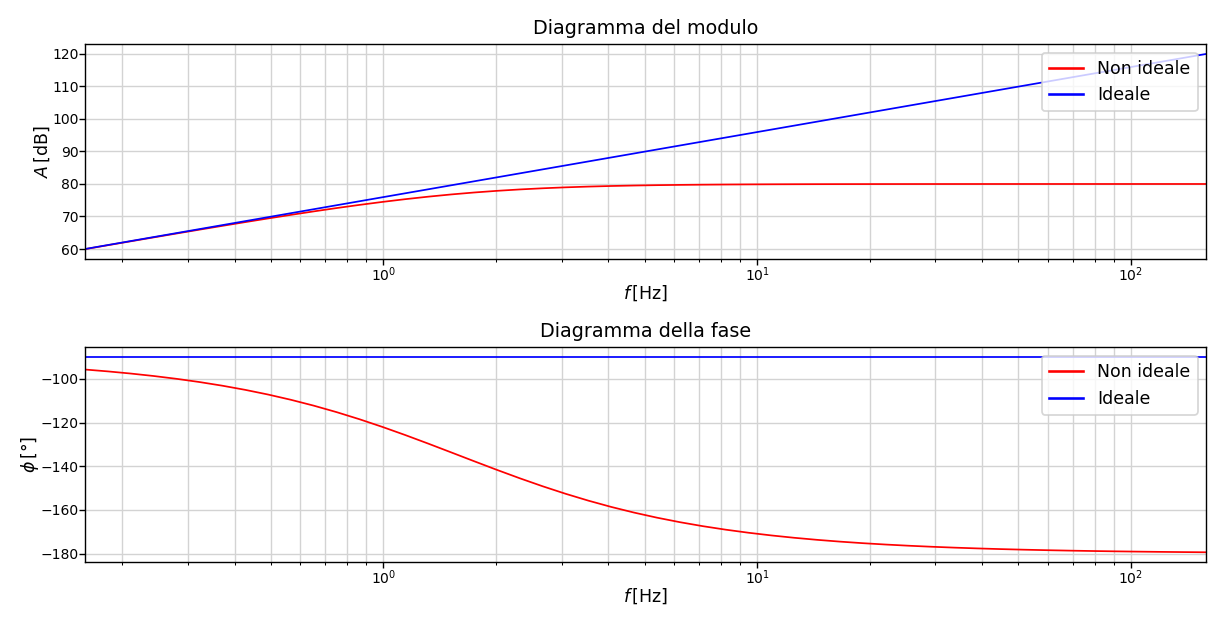

Output()

In [3]:
# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

l1 = f1_ax1.plot([], [], color='red')
l2 = f1_ax2.plot([], [], color='red') 
l3 = f1_ax1.plot([], [], color='blue')
l4 = f1_ax2.plot([], [], color='blue')  

f1_line1 = l1[0]
f1_line2 = l2[0]
f1_line3 = l3[0]
f1_line4 = l4[0]
    
f1_ax1.legend(l1+l3, ['Non ideale', 'Ideale'], loc=1)
f1_ax2.legend(l2+l4, ['Non ideale', 'Ideale'], loc=1)

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='x', tight=True)
f1_ax2.autoscale(enable=True, axis='x', tight=True)
f1_ax1.autoscale(enable=True, axis='y', tight=False)
f1_ax2.autoscale(enable=True, axis='y', tight=False)

f1_ax1.set_title('Diagramma del modulo', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Diagramma della fase', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)  

# System model

def system_model(cg, rf, a):

    Rf = rf / 1000      # Convert to Ohm
    Cg = cg * 1000000   # Convert to Farad

    W_ideal = c.tf([-Rf*Cg, 0], [1])
    W_ac = c.tf([-Rf*Cg*a, 0], [Rf*Cg, a+1])
    
    global f1_line1, f1_line2, f1_line3, f1_line4
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)
    f1_ax1.lines.remove(f1_line3)
    f1_ax2.lines.remove(f1_line4)

    mag, phase, omega = c.bode_plot(W_ac, Plot=False)   # Non-ideal Bode-plot
    f1_line1, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='red')
    f1_line2, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='red') 
    
    mag, phase, omega = c.bode_plot(W_ideal, omega=omega, Plot=False)   # Ideal Bode-plot at the non-ideal points
    f1_line3, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f1_line4, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   

    f1_ax1.relim()
    f1_ax2.relim()

    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    
    print('Funzione di trasferimento PD ideale:')
    print(W_ideal)
    print('\nFunzione di trasferimento PD non ideale:')
    print(W_ac)
    
# GUI widgets
    
rf_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$R_f$$\ [k\Omega]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
cg_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$C_g$$\ [\mu H]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})

input_data = w.interactive_output(system_model, {'rf':rf_slider, 'cg':cg_slider, 'a':opampGain})

display(w.HBox([cg_slider, rf_slider]), input_data)

Questa implementazione del controller PD, sebbene molto semplice, presenta alcuni difetti, inclusa la sua elevata sensibilità al rumore. Per ridurre questo problema, è possibile inserire una resistenza nel percorso di feedforward che comunque non altera la forma della funzione di trasferimento del sistema.
<br><br>
<img src="Images/diff2.png" width="30%" />
<br>
<b>Modifica i componenti passivi in modo che il sistema non ideale sia il più vicino possibile all'ideale! Quali sono le differenze rispetto al modello precedente?</b>

<IPython.core.display.Javascript object>


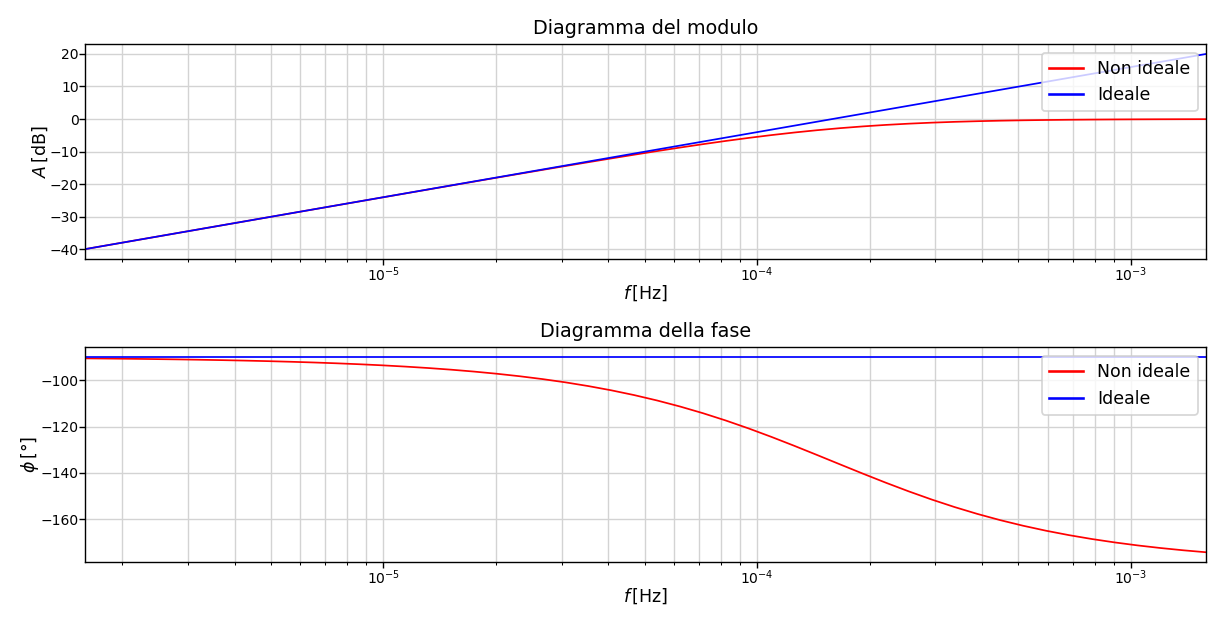

Output()

In [4]:
# Filtered PD - serial (with "stop")

fig2, ((f2_ax1), (f2_ax2)) = plt.subplots(2, 1)
fig2.set_size_inches((9.8, 5))
fig2.set_tight_layout(True)

l1 = f2_ax1.plot([], [], color='red')
l2 = f2_ax2.plot([], [], color='red') 
l3 = f2_ax1.plot([], [], color='blue')
l4 = f2_ax2.plot([], [], color='blue')  

f2_line1 = l1[0]
f2_line2 = l2[0]
f2_line3 = l3[0]
f2_line4 = l4[0]

f2_ax1.legend(l1+l3, ['Non ideale', 'Ideale'], loc=1)
f2_ax2.legend(l2+l4, ['Non ideale', 'Ideale'], loc=1)

f2_ax1.grid(which='both', axis='both', color='lightgray')
f2_ax2.grid(which='both', axis='both', color='lightgray')

f2_ax1.autoscale(enable=True, axis='x', tight=True)
f2_ax2.autoscale(enable=True, axis='x', tight=True)
f2_ax1.autoscale(enable=True, axis='y', tight=False)
f2_ax2.autoscale(enable=True, axis='y', tight=False)

f2_ax1.set_title('Diagramma del modulo', fontsize=11)
f2_ax1.set_xscale('log')
f2_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f2_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f2_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f2_ax2.set_title('Diagramma della fase', fontsize=11)
f2_ax2.set_xscale('log')
f2_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f2_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f2_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

# System model

def system2_model(cg, rg, rf, a):

    Rf = rf / 1000      # Convert to Ohm
    Rg = rg / 1000 
    Cg = cg * 1000000   # Convert to Farad

    W_ideal = c.tf([-Rf*Cg, 0], [1])
    W_ac = c.tf([-Rf*Cg*a, 0], [(Rf+Rg*(a+1))*Cg, a+1])
    
    global f2_line1, f2_line2, f2_line3, f2_line4
    
    f2_ax1.lines.remove(f2_line1)
    f2_ax2.lines.remove(f2_line2)
    f2_ax1.lines.remove(f2_line3)
    f2_ax2.lines.remove(f2_line4)

    mag, phase, omega = c.bode_plot(W_ac, Plot=False)   # Non-ideal Bode-plot
    f2_line1, = f2_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='red')
    f2_line2, = f2_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='red') 
    
    mag, phase, omega = c.bode_plot(W_ideal, omega=omega, Plot=False)   # Ideal Bode-plot at the non-ideal points
    f2_line3, = f2_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f2_line4, = f2_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   

    f2_ax1.relim()
    f2_ax2.relim()
    
    f2_ax1.autoscale_view()
    f2_ax2.autoscale_view()
    
    print('Funzione di trasferimento PD ideale:')
    print(W_ideal)
    print('\nFunzione di trasferimento PD non ideale migliorata:')
    print(W_ac)
    
# GUI widgets
    
rg2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$R_g$$\ [k\Omega]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
rf2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$R_f$$\ [k\Omega]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
cg2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$C_g$$\ [\mu H]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})

input_data = w.interactive_output(system2_model, {'rg':rg2_slider, 'rf':rf2_slider, 'cg':cg2_slider, 'a':opampGain})

display(w.HBox([rg2_slider, cg2_slider, rf2_slider]), input_data)